# Baseline Code for HW1

This is just the baseline code to set up the basic function you need. You need to modify the code yourself to achieve a better result.

## Import packages you need

In [260]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## Basic Function
Do not modify this part

In [261]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()
    
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('Truth value')
    plt.ylabel('predicted value')
    plt.title('Truth v.s. Prediction')
    plt.show()

## Data and Preprocess
The function below used to:
1. Read the csv files into python
2. Choose features (you can choose yourself)
3. Split data into training and validation sets.
4. Normalization

In [262]:
# Select K best features
def getKBestFeatures(path: str, k: int):
    import pandas as pd
    from sklearn import preprocessing
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    dataPre = pd.read_csv(path)
    dataPre = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(dataPre))
    dataPreX = dataPre.iloc[:, 41:94]
    dataPreY = dataPre.iloc[:, -1]
    dataPrefit = SelectKBest(f_regression, k=5).fit(dataPreX, dataPreY)
    featScore = pd.DataFrame(dataPrefit.scores_, index=dataPreX.columns, columns=["Score"])
    feats = list(featScore.nlargest(k, "Score").index - 1)
    #print(f"Feature selected: {feats}")
    return feats

In [263]:
class Dataprocess(Dataset):
    def __init__(self,
                 path,
                 len_Feat,
                 mode='train',
                 modify=False):
        self.mode = mode

        # Read csv file
        with open(path, 'r') as f:
            data = list(csv.reader(f))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if modify == False:
            feats = list(range(93))
        else:
            # Hint:Feature Selection
            kFeat = len_Feat
            tPath = "HW1.train.csv"
            bestFeat = getKBestFeatures(tPath, kFeat)
            feats = bestFeat
            pass

        if mode == 'test':
            # Testing set
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training set
            target = data[:, -1]
            data = data[:, feats]

            # Splitting data into training and validation sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))
        
    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## Dataloader
Loads data into batches.

In [264]:
def dataloader(path,len_Feat, mode, batch_size, n_jobs=0, modify=False):
    dataset = Dataprocess(path, len_Feat, mode=mode, modify=modify)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    return dataloader

## Define DNN by pytorch
The DNN consists of 2 fully-connected layers with ReLU activation function

In [265]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim,hidden_dim):
        super(NeuralNet, self).__init__()

        # Try to modify this DNN to achieve better performance
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.BatchNorm1d(hidden_dim),
            # nn.Dropout(p=0.1),
            # nn.LeakyReLU(),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        """
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        """

        # Loss function MSE
        self.criterion = nn.MSELoss(reduction='mean')
        #RMSLELoss()
        
        
        

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # You may try regularization here

        
        return self.criterion(pred, target)
    
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

## Training

In [266]:
def train(tr_set, dv_set, model, config, device):

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer

    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])

    #optimizer = torch.optim.SGD(model.parameters(), lr=5e-4, weight_decay=1e-1)

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            #print('Saving model (epoch = {:4d}, loss = {:.4f}, dev_loss = {:.4f})'
            #    .format(epoch + 1, min_mse, dev_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            break
    print(loss_record["dev"][-1])
    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## Validation

In [267]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## Testing

In [268]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

## Hyper-parameters for DNN


In [ ]:
import optuna
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
modify = False                        # Need selection

train_path = 'HW1.train.csv'  # path to training data
test_path = 'HW1.test.csv'   # path to testing data

def objective(trial):
    features = 14
    hidden_dim = trial.suggest_int("hidden_dim", 20, 128,2)
    batch_size = trial.suggest_int("batch_size", 20, 200,10)
    early_stop = trial.suggest_int("early_stop", 20, 200,10)
    lr = trial.suggest_categorical("lr", [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0])
    momentum = trial.suggest_categorical("momentum", [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0])
    weight_decay = trial.suggest_categorical("weight_decay", [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0])
    
    config = {
    'n_epochs': 2300,                  # maximum number of epochs
    'batch_size': batch_size,                  # mini-batch size for dataloader
    'optimizer': 'SGD',                 # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                   # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': lr,                     # learning rate of SGD
        'momentum': momentum,
        'weight_decay': weight_decay
    },
    'early_stop': early_stop,                  # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'     # your model will be saved here
    }
    
    
    train_set = dataloader(train_path, features,'train', config['batch_size'], modify=True)
    validation_set = dataloader(train_path, features,'dev', config['batch_size'], modify=True)
    test_set = dataloader(test_path, features, 'test', config['batch_size'], modify=True)
    
    model = NeuralNet(train_set.dataset.dim,hidden_dim).to(device)
    
    model_loss, model_loss_record = train(train_set, validation_set, model, config, device)
    
    return model_loss

# Creating Optuna object and defining its parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 200)

# Showing optimization results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)

[I 2023-02-18 00:28:15,169] A new study created in memory with name: no-name-e4e7ad7f-d185-4bc6-957e-33f2c1458b58


Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:28:17,140] Trial 0 finished with value: 46.15211162567139 and parameters: {'hidden_dim': 106, 'batch_size': 190, 'early_stop': 170, 'lr': 0.001, 'momentum': 1e-05, 'weight_decay': 0.001}. Best is trial 0 with value: 46.15211162567139.


63.60614147186279
Finished training after 287 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:28:18,256] Trial 1 finished with value: 63.59878520965576 and parameters: {'hidden_dim': 54, 'batch_size': 110, 'early_stop': 50, 'lr': 0.1, 'momentum': 0.01, 'weight_decay': 1e-06}. Best is trial 0 with value: 46.15211162567139.


63.60098514556885
Finished training after 121 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:28:20,036] Trial 2 finished with value: 63.59876613616943 and parameters: {'hidden_dim': 52, 'batch_size': 170, 'early_stop': 80, 'lr': 0.1, 'momentum': 1e-05, 'weight_decay': 0.001}. Best is trial 0 with value: 46.15211162567139.


63.63651390075684
Finished training after 255 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:28:33,219] Trial 3 finished with value: 1.6429030895233154 and parameters: {'hidden_dim': 120, 'batch_size': 200, 'early_stop': 150, 'lr': 1e-06, 'momentum': 0.0001, 'weight_decay': 0.1}. Best is trial 3 with value: 1.6429030895233154.


1.6429030895233154
Finished training after 2300 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:28:34,349] Trial 4 finished with value: 3.03647917509079 and parameters: {'hidden_dim': 74, 'batch_size': 70, 'early_stop': 90, 'lr': 0.0001, 'momentum': 1.0, 'weight_decay': 1e-06}. Best is trial 3 with value: 1.6429030895233154.


77.7721336364746
Finished training after 96 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:28:35,814] Trial 5 finished with value: 63.598777770996094 and parameters: {'hidden_dim': 20, 'batch_size': 140, 'early_stop': 30, 'lr': 0.001, 'momentum': 0.01, 'weight_decay': 1e-05}. Best is trial 3 with value: 1.6429030895233154.


63.6025203704834
Finished training after 219 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:28:47,072] Trial 6 finished with value: 0.829495120048523 and parameters: {'hidden_dim': 96, 'batch_size': 160, 'early_stop': 150, 'lr': 0.0001, 'momentum': 0.1, 'weight_decay': 0.01}. Best is trial 6 with value: 0.829495120048523.


0.9037721991539002
Finished training after 2300 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:28:50,120] Trial 7 finished with value: 63.59877014160156 and parameters: {'hidden_dim': 42, 'batch_size': 100, 'early_stop': 100, 'lr': 0.1, 'momentum': 0.01, 'weight_decay': 0.001}. Best is trial 6 with value: 0.829495120048523.


63.63850784301758
Finished training after 428 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:28:56,298] Trial 8 finished with value: 63.599134063720705 and parameters: {'hidden_dim': 58, 'batch_size': 40, 'early_stop': 180, 'lr': 0.001, 'momentum': 1.0, 'weight_decay': 1e-05}. Best is trial 6 with value: 0.829495120048523.


69.13806457519532
Finished training after 616 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:28:58,864] Trial 9 finished with value: 63.59877319335938 and parameters: {'hidden_dim': 70, 'batch_size': 170, 'early_stop': 190, 'lr': 0.1, 'momentum': 0.1, 'weight_decay': 1e-06}. Best is trial 6 with value: 0.829495120048523.


63.64047374725342
Finished training after 381 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:29:07,063] Trial 10 finished with value: 0.8410224795341492 and parameters: {'hidden_dim': 98, 'batch_size': 140, 'early_stop': 140, 'lr': 0.0001, 'momentum': 0.1, 'weight_decay': 0.01}. Best is trial 6 with value: 0.829495120048523.


0.8486029088497162
Finished training after 1478 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:29:19,211] Trial 11 finished with value: 0.8278571009635926 and parameters: {'hidden_dim': 96, 'batch_size': 140, 'early_stop': 130, 'lr': 0.0001, 'momentum': 0.1, 'weight_decay': 0.01}. Best is trial 11 with value: 0.8278571009635926.


0.9218389391899109
Finished training after 2300 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:29:20,376] Trial 12 finished with value: 1000.0 and parameters: {'hidden_dim': 94, 'batch_size': 140, 'early_stop': 130, 'lr': 1.0, 'momentum': 1e-06, 'weight_decay': 0.01}. Best is trial 11 with value: 0.8278571009635926.


inf
Finished training after 131 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:29:21,756] Trial 13 finished with value: 89.03001708984375 and parameters: {'hidden_dim': 124, 'batch_size': 160, 'early_stop': 120, 'lr': 0.01, 'momentum': 0.001, 'weight_decay': 1.0}. Best is trial 11 with value: 0.8278571009635926.


89.79559936523438
Finished training after 182 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:29:35,806] Trial 14 finished with value: 0.9491382598876953 and parameters: {'hidden_dim': 88, 'batch_size': 90, 'early_stop': 160, 'lr': 1e-05, 'momentum': 0.1, 'weight_decay': 0.01}. Best is trial 11 with value: 0.8278571009635926.


0.9588076949119568
Finished training after 2300 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:29:49,173] Trial 15 finished with value: 0.8424440830945968 and parameters: {'hidden_dim': 110, 'batch_size': 130, 'early_stop': 200, 'lr': 0.0001, 'momentum': 0.1, 'weight_decay': 0.0001}. Best is trial 11 with value: 0.8278571009635926.


0.8575575053691864
Finished training after 2300 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:29:56,058] Trial 16 finished with value: 0.8343068689107895 and parameters: {'hidden_dim': 84, 'batch_size': 70, 'early_stop': 70, 'lr': 0.0001, 'momentum': 0.1, 'weight_decay': 0.01}. Best is trial 11 with value: 0.8278571009635926.


0.8442161858081818
Finished training after 942 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:30:14,605] Trial 17 finished with value: 0.8203634470701218 and parameters: {'hidden_dim': 112, 'batch_size': 20, 'early_stop': 110, 'lr': 0.0001, 'momentum': 0.0001, 'weight_decay': 0.01}. Best is trial 17 with value: 0.8203634470701218.


0.8261915385723114
Finished training after 1203 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:30:41,582] Trial 18 finished with value: 0.8422074407339096 and parameters: {'hidden_dim': 112, 'batch_size': 30, 'early_stop': 120, 'lr': 1e-05, 'momentum': 0.0001, 'weight_decay': 0.1}. Best is trial 17 with value: 0.8203634470701218.


0.862843570113182
Finished training after 2300 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:30:42,890] Trial 19 finished with value: 1000.0 and parameters: {'hidden_dim': 78, 'batch_size': 20, 'early_stop': 60, 'lr': 1.0, 'momentum': 0.0001, 'weight_decay': 0.0001}. Best is trial 17 with value: 0.8203634470701218.


1526594290476646.5
Finished training after 61 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:30:44,397] Trial 20 finished with value: 89.26803398132324 and parameters: {'hidden_dim': 126, 'batch_size': 50, 'early_stop': 100, 'lr': 0.01, 'momentum': 0.001, 'weight_decay': 1.0}. Best is trial 17 with value: 0.8203634470701218.


89.73398303985596
Finished training after 123 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:30:58,828] Trial 21 finished with value: 0.8295438528060913 and parameters: {'hidden_dim': 100, 'batch_size': 120, 'early_stop': 140, 'lr': 0.0001, 'momentum': 1e-06, 'weight_decay': 0.01}. Best is trial 17 with value: 0.8203634470701218.


0.8316532015800476
Finished training after 2300 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:31:10,333] Trial 22 finished with value: 0.8388014435768127 and parameters: {'hidden_dim': 114, 'batch_size': 160, 'early_stop': 110, 'lr': 0.0001, 'momentum': 0.0001, 'weight_decay': 0.01}. Best is trial 17 with value: 0.8203634470701218.


0.8702199220657348
Finished training after 1932 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:31:22,151] Trial 23 finished with value: 0.8266822040081024 and parameters: {'hidden_dim': 90, 'batch_size': 180, 'early_stop': 160, 'lr': 0.0001, 'momentum': 0.1, 'weight_decay': 0.01}. Best is trial 17 with value: 0.8203634470701218.


0.8449566692113877
Finished training after 2300 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:31:35,694] Trial 24 finished with value: 1.978861889243126 and parameters: {'hidden_dim': 66, 'batch_size': 190, 'early_stop': 170, 'lr': 1e-06, 'momentum': 0.1, 'weight_decay': 0.01}. Best is trial 17 with value: 0.8203634470701218.


1.978861889243126
Finished training after 2300 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:31:49,711] Trial 25 finished with value: 0.8243152171373367 and parameters: {'hidden_dim': 88, 'batch_size': 70, 'early_stop': 130, 'lr': 0.0001, 'momentum': 0.0001, 'weight_decay': 0.01}. Best is trial 17 with value: 0.8203634470701218.


0.8685877114534378
Finished training after 1923 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:31:58,270] Trial 26 finished with value: 0.8526221066713333 and parameters: {'hidden_dim': 84, 'batch_size': 60, 'early_stop': 120, 'lr': 0.0001, 'momentum': 0.0001, 'weight_decay': 0.01}. Best is trial 17 with value: 0.8203634470701218.


0.8843975901603699
Finished training after 1064 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:32:15,781] Trial 27 finished with value: 0.8354111552238465 and parameters: {'hidden_dim': 106, 'batch_size': 80, 'early_stop': 160, 'lr': 0.0001, 'momentum': 0.0001, 'weight_decay': 0.01}. Best is trial 17 with value: 0.8203634470701218.


0.8472009420394897
Finished training after 2300 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


[I 2023-02-18 00:32:20,290] Trial 28 finished with value: 1.0325690746307372 and parameters: {'hidden_dim': 88, 'batch_size': 40, 'early_stop': 100, 'lr': 0.0001, 'momentum': 0.0001, 'weight_decay': 1.0}. Best is trial 17 with value: 0.8203634470701218.


1.0417081475257874
Finished training after 447 epochs
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


## Read the dataset

In [253]:
hidden_dim = 84
config = {
    'n_epochs': 10000,                  # maximum number of epochs
    'batch_size': 100,                  # mini-batch size for dataloader
    'optimizer': 'SGD',                 # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                   # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.0001,                     # learning rate of SGD
        'momentum': 0.1,
        'weight_decay':1e-06
    },
    'early_stop': 170,                  # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'     # your model will be saved here
    }
train_set = dataloader(train_path, 14,'train', config['batch_size'], modify=True)
validation_set = dataloader(train_path, 14,'dev', config['batch_size'], modify=True)
test_set = dataloader(test_path,14, 'test', config['batch_size'], modify=True)

Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (500 samples found, each dim = 14)


## Try to train your DNN

In [254]:
model = NeuralNet(train_set.dataset.dim,hidden_dim).to(device)  # Construct model and move to device

In [255]:
model_loss, model_loss_record = train(train_set, validation_set, model, config, device)


Saving model (epoch =    1, loss = 8.5870, dev_loss = 8.5870)
Saving model (epoch =    2, loss = 7.0563, dev_loss = 7.0563)
Saving model (epoch =    3, loss = 5.6982, dev_loss = 5.6982)
Saving model (epoch =    4, loss = 4.7970, dev_loss = 4.7970)
Saving model (epoch =    5, loss = 3.9852, dev_loss = 3.9852)
Saving model (epoch =    6, loss = 3.3644, dev_loss = 3.3644)
Saving model (epoch =    7, loss = 3.0185, dev_loss = 3.0185)
Saving model (epoch =    8, loss = 2.5460, dev_loss = 2.5460)
Saving model (epoch =    9, loss = 2.2614, dev_loss = 2.2614)
Saving model (epoch =   10, loss = 2.0760, dev_loss = 2.0760)
Saving model (epoch =   11, loss = 1.8323, dev_loss = 1.8323)
Saving model (epoch =   12, loss = 1.7068, dev_loss = 1.7068)
Saving model (epoch =   13, loss = 1.6495, dev_loss = 1.6495)
Saving model (epoch =   14, loss = 1.5204, dev_loss = 1.5204)
Saving model (epoch =   15, loss = 1.4658, dev_loss = 1.4658)
Saving model (epoch =   16, loss = 1.4294, dev_loss = 1.4294)
Saving m

Saving model (epoch =  625, loss = 0.8441, dev_loss = 0.8441)
Saving model (epoch =  637, loss = 0.8435, dev_loss = 0.8435)
Saving model (epoch =  654, loss = 0.8433, dev_loss = 0.8433)
Saving model (epoch =  656, loss = 0.8423, dev_loss = 0.8423)
Saving model (epoch =  660, loss = 0.8419, dev_loss = 0.8419)
Saving model (epoch =  669, loss = 0.8413, dev_loss = 0.8413)
Saving model (epoch =  676, loss = 0.8412, dev_loss = 0.8412)
Saving model (epoch =  694, loss = 0.8402, dev_loss = 0.8402)
Saving model (epoch =  697, loss = 0.8397, dev_loss = 0.8397)
Saving model (epoch =  723, loss = 0.8388, dev_loss = 0.8388)
Saving model (epoch =  754, loss = 0.8375, dev_loss = 0.8375)
Saving model (epoch =  767, loss = 0.8365, dev_loss = 0.8365)
Saving model (epoch =  808, loss = 0.8357, dev_loss = 0.8357)
Saving model (epoch =  814, loss = 0.8356, dev_loss = 0.8356)
Saving model (epoch =  838, loss = 0.8355, dev_loss = 0.8355)
Saving model (epoch =  855, loss = 0.8350, dev_loss = 0.8350)
Saving m

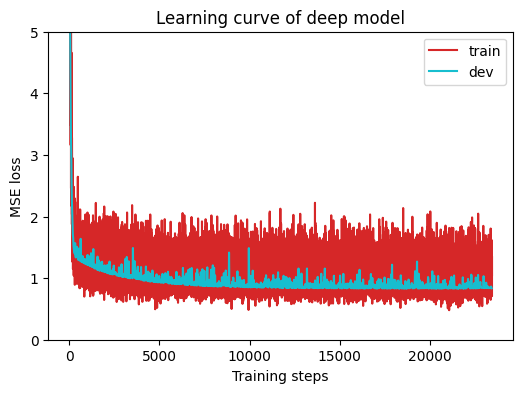

In [256]:
plot_learning_curve(model_loss_record, title='deep model')

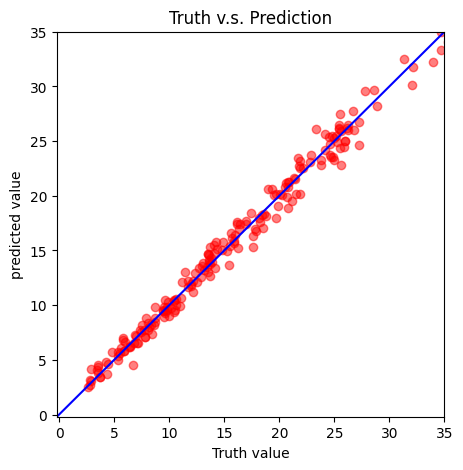

In [257]:
del model
model = NeuralNet(train_set.dataset.dim,hidden_dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(validation_set, model, device)  # Show prediction on the validation set

## Testing
Get the prediction result and save it to csv file named 'prediction.csv'

In [259]:
def save_pred(preds, file):
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(test_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'prediction.csv')         # save prediction file to pred.csv

Saving results to prediction.csv


In [252]:
model.eval()

NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=26, out_features=47, bias=True)
    (1): ReLU()
    (2): Linear(in_features=47, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

## Hints for better result
* Feature selection
* DNN architecture
* Training (mini-batch/optimizer/learning rate)
* Regularization